In [1]:
import os
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
import nltk
import tensorflow as tf
import keras

import pickle

import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
 
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils
from sklearn.utils import class_weight
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.utils.np_utils import to_categorical

In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [3]:
file = pd.read_csv(r"C:\Users\ydong\Desktop\Deloitte Project\Help Desk Chatbot\Intial_Analysis\data_updated.csv",encoding='ISO-8859–1')

In [4]:
file.head()

,ID,Work Item Type,Title,Track,Module,SubModule,System Function,Component Name,Repro Steps
0,44575,Bug,Case Mode is incorrectly populated with Progra...,Worker Portal,System Reports,NaN,RP â Other,Inquiry - QuickSearch - Case Summary Design,"Defect Description: CASH case is created, then..."
1,44599,Bug,"After eligibility has been run, âContinue pr...",Worker Portal,NaN,NaN,WP - Other,Inquiry - QuickSearch - Case Summary Design,Defect Description: If eligibility has been ru...
2,44833,Bug,Outbound Header record layout- Incorrect issua...,Benefit Management,Issuance,NaN,BM - Other,DED2.2.3 Benefit_Management_Document_EB_Paymen...,Case No-100000107\r\nCaseNo-100000346- STL1\r\...
3,45036,Bug,âProgram Complianceâ button on Individual ...,Worker Portal,SNAP,NaN,WP - Other,Inquiry - QuickSearch - Case Summary Design,Case/Application Number: 100000072 \r\nDefect ...
4,45181,Bug,AP: Expense Gatepost Question Doesnât Displa...,Applicant Portal,Medical,NaN,AP â Screens,Expense Gatepost,Defect Description: When on the Expense Gatepo...


# Data Preprocessing + Customized Function

In [5]:
def clean_text(text, STOPWORDS):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
#     STOPWORDS = set(stopwords)
#     USELESSWORDS = set(remove_words)
    text = text.lower() # lowercase text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
#     text = ' '.join(word for word in text.split() if word not in USELESSWORDS) # delete useless words from text
    return text

In [6]:
def clean_text1(text, stopwords):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords)
    text = text.lower() # lowercase text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [7]:
def kill_numbers(text):
    #print(text)
    split = text.split()
    split = ['' if i.isdigit() and len(i)<20 else i for i in split]
    join = ' '.join(split).strip()
    #print(join)
    return join

In [8]:
def kill_more_numbers(text):
    text = text.split()
    pattern = '[0-9]'
    l = [re.sub(pattern, '', i) for i in text]
    output = ' '.join(l)
    return output

In [9]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [10]:
def lemmatize_df(txt):
#     stop_words = set(stopwords.words('english'))
    tokenized = sent_tokenize(txt) 
    try:
        for i in tokenized: 
            #print(tokenized)
            if i.isdigit():
            #    print(i)
                i = ''
                #wordsList = nltk.word_tokenize(i)
                #print(wordsList)
            #if len(i)==1:
            #    i=''
                
            wordsList = nltk.word_tokenize(i) 

            # removing stop words from wordList 
            wordsList = [w for w in wordsList if not w in set(stopwords)]    
            tag = nltk.pos_tag(wordsList)
            #print(tagged)

        lemmatizer = WordNetLemmatizer() 
        tagged = [(i[0], i[1].replace(i[1], get_wordnet_pos(i[1]))) for i in tag]

        tagged = [(i[0], i[1]) if i[1]!='' else (i[0], 'n') for i in tagged]
        row = [lemmatizer.lemmatize(i[0], pos=i[1]) for i in tagged]
        row = ' '.join(row)
        return row
    except:
        return txt

In [11]:
def stem_words(text):
    text = text.split()
    ps = PorterStemmer()
    output = [ps.stem(i) for i in text]
    output = ' '.join(output)
    return output

In [12]:
def remove_single_letter(text):
    text = text.split()
    out = [i for i in text if len(i)>1]
    out = ' '.join(out)
    return out

In [13]:
def get_predictions_probability(model, data, encoder, df, subset, model_type):
    if model_type == 'MLP':
        preds_proba = model.predict(data)
        max_label_encoded = np.argmax(preds_proba,axis=1)
        max_proba = np.max(preds_proba, axis=1)
        preds = encoder.inverse_transform(max_label_encoded)
    else:
        preds_proba = model.predict_proba(data)
        preds = model.predict(data)
        preds = encoder.inverse_transform(preds)
        max_label_encoded = np.argmax(preds_proba,axis=1)
        max_proba = np.max(preds_proba,axis=1)
    df['Predicted_'+model_type] = preds
    df['Confidence_'+model_type] = max_proba
    df['Dataset'] = subset
    return df

In [14]:
def get_predictions_probability1(model, data, encoder, df, subset, model_type):
    if model_type == 'MLP':
        preds_proba = model.predict(data)
        max_label_encoded = np.argmax(preds_proba,axis=1)
        max_proba = np.max(preds_proba, axis=1)
        preds = encoder.inverse_transform(max_label_encoded)
    else:
        preds_proba = model.predict_proba(data)
        #preds = model.predict(data)
        preds, max_proba = category_select(preds_proba, category_lst)
#         preds = encoder.inverse_transform(preds)
#         max_label_encoded = np.argmax(preds_proba,axis=1)
#         max_proba = np.max(preds_proba,axis=1)
    df['Predicted_'+model_type] = preds
    df['Confidence_'+model_type] = max_proba
    df['Dataset'] = subset
    return df

In [15]:
def print_evaluation(df, model_type, confidence_threshold=0):
    if confidence_threshold>0:
        mask = df['Confidence_'+model_type]>=confidence_threshold
        df = df[mask]
    print('Classification Report for %s:'%(model_type))
    print('\n')
    print(classification_report(df['Actual'], df['Predicted_'+model_type]))

In [16]:
file = file[['ID', 'Title', 'Module', 'Repro Steps']]
file.head()

,ID,Title,Module,Repro Steps
0,44575,Case Mode is incorrectly populated with Progra...,System Reports,"Defect Description: CASH case is created, then..."
1,44599,"After eligibility has been run, âContinue pr...",NaN,Defect Description: If eligibility has been ru...
2,44833,Outbound Header record layout- Incorrect issua...,Issuance,Case No-100000107\r\nCaseNo-100000346- STL1\r\...
3,45036,âProgram Complianceâ button on Individual ...,SNAP,Case/Application Number: 100000072 \r\nDefect ...
4,45181,AP: Expense Gatepost Question Doesnât Displa...,Medical,Defect Description: When on the Expense Gatepo...


In [17]:
remove_words = ["repro steps", "defect", "description", "steps", "actual", "issue", "environment", "application","number", 
                "stl1", "case","no", "case", "expected", "screen", "steps to repro", "casenumber", "summary", 
                "steps","to","reproduce", "application", "case no", "actual", "expected","result", "actual","result"]

#title: 
remove_words_cap = [word.title() for word in remove_words]

In [18]:
remove_words=remove_words + remove_words_cap

In [19]:
#add stop words 

stopwords = nltk.corpus.stopwords.words('english')

newStopWords =remove_words
stopwords.extend(newStopWords)


In [20]:
file = file[file["Module"].isin(["SNAP", "RFI", "NMAGI"])]

In [21]:
file.Module.unique()

array(['SNAP', 'NMAGI', 'RFI'], dtype=object)

In [22]:
file1 = file
file1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2620 entries, 3 to 14904
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2620 non-null   int64 
 1   Title        2620 non-null   object
 2   Module       2620 non-null   object
 3   Repro Steps  2620 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.3+ KB


In [23]:
file1.dropna(inplace=True)
file1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2620 entries, 3 to 14904
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2620 non-null   int64 
 1   Title        2620 non-null   object
 2   Module       2620 non-null   object
 3   Repro Steps  2620 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.3+ KB


In [24]:
file1.drop_duplicates(subset="ID", keep="first", inplace=True)
file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2620 entries, 3 to 14904
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2620 non-null   int64 
 1   Title        2620 non-null   object
 2   Module       2620 non-null   object
 3   Repro Steps  2620 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.3+ KB


In [25]:
file1.reset_index(drop=True, inplace=True)
file1.head()

,ID,Title,Module,Repro Steps
0,45036,âProgram Complianceâ button on Individual ...,SNAP,Case/Application Number: 100000072 \r\nDefect ...
1,46284,Worker Portal - Education Details : Graduation...,SNAP,Case No: 100000340\r\n\r\n1. A 3 Member househ...
2,46286,Interface : SDX : On running SDX file in STL1 ...,NMAGI,"On running SDX file, getting exception âThe ..."
3,46404,ApplicationRegistration Summary - On clicking ...,SNAP,https://sts1-wp.one.or.gov/\r\n\r\nApplication...
4,46408,Graduation date is displayed as mandatory even...,SNAP,"1) Create a SNAP, TANF and Medical case for a ..."


<AxesSubplot:>

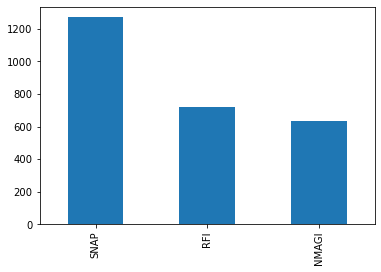

In [26]:
file1.Module.value_counts().plot(kind="bar")

In [27]:
file1['Repro Steps'] = file1['Repro Steps'].astype(str).map(lambda x: clean_text(x, set(stopwords)))
file1['Repro Steps'] = file1['Repro Steps'].apply(lambda x: kill_numbers(x))
file1['Repro Steps'] = file1['Repro Steps'].apply(lambda x: kill_more_numbers(x))
file1['Repro Steps'] = file1['Repro Steps'].astype(str).apply(lambda x: lemmatize_df(x))
# file1['Repro Steps'] = file1['Repro Steps'].astype(str).apply(lambda x: stem_words(x))
file1['Repro Steps'] = file1['Repro Steps'].astype(str).apply(lambda x: remove_single_letter(x))
file1 = file1[file1['Repro Steps']!='']
file1 = file1[file1['Repro Steps']!=' ']
print(file1.shape)
file1.head(10)

(2620, 4)


,ID,Title,Module,Repro Steps
0,45036,âProgram Complianceâ button on Individual ...,SNAP,clicking program compliance button individual ...
1,46284,Worker Portal - Education Details : Graduation...,SNAP,member household applying cash medical snap mo...
2,46286,Interface : SDX : On running SDX file in STL1 ...,NMAGI,running sdx file getting exception procedure u...
3,46404,ApplicationRegistration Summary - On clicking ...,SNAP,https stswponeorgov application# create snap o...
4,46408,Graduation date is displayed as mandatory even...,SNAP,create snap tanf medical mother father child a...
5,46409,Applicant Portal : Deselecting trust resource ...,SNAP,log citizen start new select cash snap program...
6,46418,RFI not generated for Relationship for a SNAP ...,RFI,per test marked relationship verification veri...
7,46421,BPR Defect - AP: Interview Task Created for a ...,SNAP,signing submitting expedited snap interview ta...
8,46428,MMIS Enrollment: Request a Change to make indi...,NMAGI,create individual eligible paca benefits add i...
9,46438,MMIS Enrollment- Retroactive benefits for PREG...,NMAGI,create individual eligible retroactive preg be...


In [28]:
# file1 = file1[["Module", "Repro Steps"]]

In [29]:
file1.head()

,ID,Title,Module,Repro Steps
0,45036,âProgram Complianceâ button on Individual ...,SNAP,clicking program compliance button individual ...
1,46284,Worker Portal - Education Details : Graduation...,SNAP,member household applying cash medical snap mo...
2,46286,Interface : SDX : On running SDX file in STL1 ...,NMAGI,running sdx file getting exception procedure u...
3,46404,ApplicationRegistration Summary - On clicking ...,SNAP,https stswponeorgov application# create snap o...
4,46408,Graduation date is displayed as mandatory even...,SNAP,create snap tanf medical mother father child a...


# Test and Train Data Split 

In [30]:
df_train, df_test = train_test_split(file1, test_size = 0.25, shuffle = True, stratify=file1['Module'], random_state=42)
# df_train = pd.concat([df_train, duplicates], axis=0)
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)
print('Train Shape is:',df_train.shape)
print('Test Shape is:',df_test.shape)
print('Final Train-Test ratio:', str(round(df_train.shape[0]/(df_train.shape[0]+df_test.shape[0]),2))+'-'+str(round(df_test.shape[0]/(df_train.shape[0]+df_test.shape[0]),2)))

Train Shape is: (1965, 4)
Test Shape is: (655, 4)
Final Train-Test ratio: 0.75-0.25


In [31]:
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words = 'english')#, ngram_range=(2,2))
vectors = vectorizer.fit(df_train['Repro Steps'].astype(str))
pickle.dump(vectorizer, open("vectorizer.pickle", "wb"))
x_train_vectors = vectors.transform(df_train['Repro Steps'].astype(str))
feature_names = vectors.get_feature_names()
dense = x_train_vectors.todense()
denselist = dense.tolist()
x_train = pd.DataFrame(denselist, columns=feature_names)

x_test_vectors = vectors.transform(df_test['Repro Steps'].astype(str))
feature_names = vectors.get_feature_names()
dense = x_test_vectors.todense()
denselist = dense.tolist()
x_test = pd.DataFrame(denselist, columns=feature_names)
print('Train Shape is:',x_train.shape)
print('Test Shape is:',x_test.shape)
x_train.head(10)

Train Shape is: (1965, 5900)
Test Shape is: (655, 5900)


____________________________________________________________________________________  \
0                                                0.0                                      
1                                                0.0                                      
2                                                0.0                                      
3                                                0.0                                      
4                                                0.0                                      
5                                                0.0                                      
6                                                0.0                                      
7                                                0.0                                      
8                                                0.0                                      
9                                                0.0                                      

   __hhc_nmgi_determine_msp_recipient  __hhc_nmgi_determine_osipm_recipient  \
0                                 0.0                                   0.0   
1                                 0.0                                   0.0   
2                                 0.0                                   0.0   
3                                 0.0                                   0.0   
4                                 0.0                                   0.0   
5                                 0.0                                   0.0   
6                                 0.0                                   0.0   
7                                 0.0                                   0.0   
8                                 0.0                                   0.0   
9                                 0.0                                   0.0   

   __hhc_snap_residential_care_facility  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   
5                                   0.0   
6                                   0.0   
7                                   0.0   
8                                   0.0   
9                                   0.0   

   __in_snap_self_employment_income_projection  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   
5                                          0.0   
6                                          0.0   
7                                          0.0   
8                                          0.0   
9                                          0.0   

   __nf_snap_employment_services_exempt  __rfi_process_identity_individuals  \
0                                   0.0                                 0.0   
1                                   0.0                                 0.0   
2                                   0.0                                 0.0   
3                                   0.0                                 0.0   
4                                   0.0                                 0.0   
5                                   0.0                                 0.0   
6                                   0.0                                 0.0   
7                                   0.0                                 0.0   
8                                   0.0                                 0.0   
9                                   0.0                                 0.0   

   __rsc_nmgiadd_transferredresource  __set_rfi_noncitizen_missing_info  \
0                                0.0                                0.0   
1                                0.0                                0.0   
2          

In [32]:
import pickle
pickle.dump(vectors, open("vectorizer.pickle", "wb"))

In [33]:
encoder = LabelEncoder()
encoder = encoder.fit(df_train['Module'])
train_labels = encoder.transform(df_train['Module'])
test_labels = encoder.transform(df_test['Module'])

In [34]:
pickle.dump(encoder, open("encoder.pickle", "wb"))

In [35]:
visual_mapping = pd.DataFrame()
visual_mapping['Category'] = df_train['Module']
visual_mapping['Encoded Label'] = train_labels
visual_mapping.head(10)

,Category,Encoded Label
0,NMAGI,0
1,RFI,1
2,NMAGI,0
3,SNAP,2
4,NMAGI,0
5,SNAP,2
6,RFI,1
7,NMAGI,0
8,SNAP,2
9,RFI,1


# Random Forest Model Classifier

In [36]:
model_rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced', n_estimators=500, max_features='auto')
model_rf.fit(x_train, train_labels)

RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=-1,
                       random_state=42)

In [37]:
rf_probability=model_rf.predict_proba(x_test)

In [38]:
rf_probability

array([[0.068     , 0.064     , 0.868     ],
       [0.178     , 0.63      , 0.192     ],
       [0.198     , 0.04      , 0.762     ],
       ...,
       [0.16971557, 0.19      , 0.64028443],
       [0.186     , 0.526     , 0.288     ],
       [0.378     , 0.54      , 0.082     ]])

In [39]:
dummy = rf_probability[rf_probability>0.33]
dummy

array([0.868     , 0.63      , 0.762     , 0.706     , 0.728     ,
       0.42      , 0.422     , 0.698     , 0.336     , 0.548     ,
       0.65      , 0.892     , 0.572     , 0.864     , 0.494     ,
       0.35      , 0.442     , 0.492     , 0.344     , 0.47      ,
       0.478     , 0.546     , 0.406     , 0.564     , 0.742     ,
       0.484     , 0.58      , 0.74      , 0.876     , 0.544     ,
       0.334     , 0.912     , 0.872     , 0.774     , 0.62      ,
       0.598     , 0.714     , 0.566     , 0.742     , 0.604     ,
       0.75933099, 0.686     , 0.874     , 0.452     , 0.858     ,
       0.834     , 0.56      , 0.348     , 0.49      , 0.924     ,
       0.788     , 0.494     , 0.406     , 0.728     , 0.69239832,
       0.634     , 0.728     , 0.692     , 0.336     , 0.482     ,
       0.774     , 0.826     , 0.672     , 0.394     , 0.372     ,
       0.412     , 0.536     , 0.816     , 0.812     , 0.774     ,
       0.834     , 0.66      , 0.896     , 0.764     , 0.87   

In [40]:
category_lst = ["SNAP", "RFI", "NMAGI"]

In [41]:
def category_select(arr, category_lst):
    cat_ar = []
    prob_ar = []
    for i in arr:
        lst = np.where(i>0.33)
#         print(lst[0])
        cat_ar.append([category_lst[j] for j in lst[0]])
        prob_ar.append([i[j] for j in lst[0]])
    return cat_ar, prob_ar

In [42]:
results_test = pd.DataFrame()
results_test['Actual'] = df_test['Module']
results_test['Keyword'] = df_test['Repro Steps']
results_test = get_predictions_probability1(model_rf, x_test, encoder, results_test, 'Test', 'RF')
results_test = results_test[['Keyword', 'Actual', 'Predicted_RF', 'Confidence_RF', 'Dataset']]
results_test.head(10)

,Keyword,Actual,Predicted_RF,Confidence_RF,Dataset
0,approved snap individual female years old clic...,SNAP,[NMAGI],[0.868],Test
1,repro create person household ssa returns inca...,RFI,[RFI],[0.63],Test
2,pick individual dsnap benefits benefit issuanc...,SNAP,[NMAGI],[0.762],Test
3,created snap+cash sts added state benefits sta...,RFI,[RFI],[0.706],Test
4,envinornmentstu casenumber descriptionbenefit ...,SNAP,[NMAGI],[0.728],Test
5,sts medical medical created follows aunt hoh a...,NMAGI,"[SNAP, NMAGI]","[0.42, 0.422]",Test
6,iecasenumber breaking running eligibility chec...,NMAGI,[NMAGI],[0.698],Test
7,self employment income added individual edbc r...,SNAP,"[SNAP, NMAGI]","[0.336, 0.548]",Test
8,observed testing cr resource falling cpc perio...,NMAGI,[SNAP],[0.65],Test
9,casenumber envinornmentstsu repro worker picks...,SNAP,[NMAGI],[0.892],Test


# Model Evaluation - 87% accuracy rate - F1 score


# Demo

In [44]:
def test_demo(string):
    category_list=['NMAGI','RFI','SNAP']
    d = pd.DataFrame({'Repro Steps': [string]})
    d['Repro Steps'] = d['Repro Steps'].astype(str).map(lambda x: clean_text(x, set(stopwords)))
    d['Repro Steps'] = d['Repro Steps'].apply(lambda x: kill_numbers(x))
    d['Repro Steps'] = d['Repro Steps'].apply(lambda x: kill_more_numbers(x))
    d['Repro Steps'] = d['Repro Steps'].astype(str).apply(lambda x: lemmatize_df(x))
    d['Repro Steps'] = d['Repro Steps'].astype(str).apply(lambda x: remove_single_letter(x))
    d = d[d['Repro Steps']!='']
    d = d[d['Repro Steps']!=' ']
    d_vectors = vectors.transform(d['Repro Steps'].astype(str))
    feature_names = vectors.get_feature_names()
    dense = d_vectors.todense()
    denselist = dense.tolist()
    demo_test = pd.DataFrame(denselist, columns=feature_names)
    demo_probability=model_rf.predict_proba(demo_test)
    demo_list = demo_probability.ravel().tolist()
    index = []
    for i in range(0,3):
        if demo_list[i] > 0.33:
            index.append(i)
    category=[]
    for i in index:
        category.append(category_list[i])
    print(category)

In [57]:
demo=input()
test_demo(demo)

-  Worker is not able to establish a new Date of Request
['SNAP']


# checking feature importance

In [38]:
importance_df = pd.DataFrame()
importance_df['Features'] = x_test.columns
importance_df['Importance'] = model_rf.feature_importances_
importance_df=importance_df.sort_values('Importance', ascending=False)
importance_df['Normed Importance'] = importance_df['Importance']/importance_df['Importance'].sum()
importance_df['Normed Importance'] = importance_df['Normed Importance']*100
importance_df.reset_index(drop=True, inplace=True)
print('The Contribution of the top 20 features is:', str(round(importance_df.loc[:21, 'Normed Importance'].sum()))+'%')
importance_df.head(15)

The Contribution of the top 20 features is: 29.0%


,Features,Importance,Normed Importance
0,rfi,0.065112,6.511214
1,snap,0.060957,6.095704
2,generated,0.022446,2.244643
3,verification,0.022358,2.235780
4,individual,0.013134,1.313450
5,medical,0.011453,1.145324
6,eligibility,0.009900,0.990045
7,run,0.009329,0.932861
8,selg,0.007397,0.739670
9,income,0.006096,0.609577


In [39]:
from sklearn.naive_bayes import MultinomialNB

In [40]:
#NB
model_mnb = MultinomialNB()
model_mnb.fit(x_train, train_labels)
mnb_pred = model_mnb.predict(x_test)

In [41]:
results_test_nb = pd.DataFrame()
results_test_nb['Actual'] = df_test['Module']
results_test_nb['Keyword'] = df_test['Repro Steps']
results_test_nb = get_predictions_probability(model_mnb, x_test, encoder, results_test_nb, 'Test', 'NB')
results_test_nb = results_test_nb[['Keyword', 'Actual', 'Predicted_NB', 'Confidence_NB', 'Dataset']]
results_test_nb.head(10)

,Keyword,Actual,Predicted_NB,Confidence_NB,Dataset
0,approved snap individual female years old clic...,SNAP,SNAP,0.943786,Test
1,repro create person household ssa returns inca...,RFI,RFI,0.653841,Test
2,pick individual dsnap benefits benefit issuanc...,SNAP,SNAP,0.949135,Test
3,created snap+cash sts added state benefits sta...,RFI,RFI,0.673608,Test
4,envinornmentstu casenumber descriptionbenefit ...,SNAP,SNAP,0.856963,Test
5,sts medical medical created follows aunt hoh a...,NMAGI,SNAP,0.737347,Test
6,iecasenumber breaking running eligibility chec...,NMAGI,SNAP,0.773284,Test
7,self employment income added individual edbc r...,SNAP,SNAP,0.715088,Test
8,observed testing cr resource falling cpc perio...,NMAGI,NMAGI,0.667503,Test
9,casenumber envinornmentstsu repro worker picks...,SNAP,SNAP,0.966006,Test


In [43]:
mnb_probability=model_mnb.predict_proba(x_test)

In [44]:
mnb_probability

array([[0.02017633, 0.03603756, 0.94378611],
       [0.16980881, 0.65384108, 0.17635011],
       [0.01350087, 0.03736384, 0.94913529],
       ...,
       [0.06001696, 0.12429987, 0.81568318],
       [0.10685372, 0.46759332, 0.42555296],
       [0.26498541, 0.68884796, 0.04616663]])

In [113]:
print_evaluation(results_test_nb, 'NB')

Classification Report for NB:


              precision    recall  f1-score   support

       NMAGI       0.87      0.59      0.71       158
         RFI       0.95      0.54      0.69       179
        SNAP       0.71      0.99      0.82       318

    accuracy                           0.77       655
   macro avg       0.84      0.71      0.74       655
weighted avg       0.81      0.77      0.76       655



In [47]:
#SVC
model_svc = SVC(probability=True, class_weight='balanced', random_state=42)
model_svc.fit(x_train, train_labels)
results_test_svc = pd.DataFrame()
results_test_svc['Actual'] = df_test['Module']
results_test_svc['Keyword'] = df_test['Repro Steps']
results_test_svc = get_predictions_probability(model_svc, x_test, encoder, results_test, 'Test', 'SVC')
results_test_svc = results_test_svc[['Keyword', 'Actual', 'Predicted_SVC', 'Confidence_SVC', 'Dataset']]
results_test_svc.head(10)

,Keyword,Actual,Predicted_SVC,Confidence_SVC,Dataset
0,approved snap individual female years old clic...,SNAP,SNAP,0.984980,Test
1,repro create person household ssa returns inca...,RFI,RFI,0.837659,Test
2,pick individual dsnap benefits benefit issuanc...,SNAP,SNAP,0.993212,Test
3,created snap+cash sts added state benefits sta...,RFI,RFI,0.996237,Test
4,envinornmentstu casenumber descriptionbenefit ...,SNAP,SNAP,0.958361,Test
5,sts medical medical created follows aunt hoh a...,NMAGI,NMAGI,0.586744,Test
6,iecasenumber breaking running eligibility chec...,NMAGI,SNAP,0.940344,Test
7,self employment income added individual edbc r...,SNAP,SNAP,0.665988,Test
8,observed testing cr resource falling cpc perio...,NMAGI,NMAGI,0.941154,Test
9,casenumber envinornmentstsu repro worker picks...,SNAP,SNAP,0.993932,Test


In [48]:
svc_probability=model_svc.predict_proba(x_test)

In [49]:
svc_probability

array([[0.00550511, 0.00951517, 0.98497972],
       [0.14721144, 0.83765898, 0.01512958],
       [0.00166896, 0.00511937, 0.99321167],
       ...,
       [0.0930693 , 0.07241266, 0.83451805],
       [0.12890283, 0.72899693, 0.14210024],
       [0.69803865, 0.29383838, 0.00812297]])

In [116]:
print_evaluation(results_test_svc, 'SVC',0)

Classification Report for SVC:


              precision    recall  f1-score   support

       NMAGI       0.87      0.80      0.83       158
         RFI       0.88      0.80      0.84       179
        SNAP       0.87      0.95      0.91       318

    accuracy                           0.87       655
   macro avg       0.87      0.85      0.86       655
weighted avg       0.87      0.87      0.87       655



In [76]:
print_evaluation(results_test_svc, 'SVC',0.9)

Classification Report for SVC:


              precision    recall  f1-score   support

       NMAGI       0.93      0.95      0.94        85
         RFI       0.95      0.91      0.93        91
        SNAP       0.98      0.99      0.98       206

    accuracy                           0.96       382
   macro avg       0.95      0.95      0.95       382
weighted avg       0.96      0.96      0.96       382



In [117]:
#xgboost
model_xgb = XGBClassifier(random_state = 42, n_jobs=-1, subsample = 0.85, colsample_bytree=0.75, max_depth=5, n_estimators=400)
model_xgb.fit(x_train, train_labels)

C:\Users\ydong\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:11:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.85,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [118]:
results_test_xgboost = pd.DataFrame()
results_test_xgboost['Actual'] = df_test['Module']
results_test_xgboost['Keyword'] = df_test['Repro Steps']
results_test_xgboost = get_predictions_probability(model_xgb, x_test, encoder, results_test, 'Test', 'XGB')
results_test_xgboost = results_test_xgboost[['Keyword', 'Actual', 'Predicted_XGB', 'Confidence_XGB', 'Dataset']]
results_test_xgboost.head(10)

C:\Users\ydong\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


,Keyword,Actual,Predicted_XGB,Confidence_XGB,Dataset
0,approved snap individual female years old clic...,SNAP,SNAP,0.999959,Test
1,repro create person household ssa returns inca...,RFI,RFI,0.998989,Test
2,pick individual dsnap benefits benefit issuanc...,SNAP,SNAP,0.999078,Test
3,created snap+cash sts added state benefits sta...,RFI,RFI,0.999525,Test
4,envinornmentstu descriptionbenefit amount calc...,SNAP,SNAP,0.999690,Test
5,sts medical medical created follows aunt hoh a...,NMAGI,NMAGI,0.936464,Test
6,iecasenumber breaking running eligibility chec...,NMAGI,SNAP,0.828411,Test
7,self employment income added individual edbc r...,SNAP,SNAP,0.959182,Test
8,observed testing cr resource falling cpc perio...,NMAGI,NMAGI,0.999133,Test
9,envinornmentstsu repro worker picks converted ...,SNAP,SNAP,0.999988,Test


In [119]:
print_evaluation(results_test_xgboost, 'XGB')

Classification Report for XGB:


              precision    recall  f1-score   support

       NMAGI       0.84      0.80      0.82       158
         RFI       0.84      0.85      0.85       179
        SNAP       0.89      0.90      0.89       318

    accuracy                           0.86       655
   macro avg       0.86      0.85      0.85       655
weighted avg       0.86      0.86      0.86       655

